In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


# Step-1: Data Gathering

In [2]:

df=pd.read_csv("spam.csv")
df.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

# Step-2: Data Preprocessing

In [4]:
(747/4825)*100 # 15% spam emails, 85% ham emails: This indicates class imbalance

15.481865284974095

In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [7]:
df_spam=df[df['Category']=='spam']
df_spam

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [9]:
df_ham.shape[0]

4825

    | Down sampling

In [10]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

    | Concatenation

In [11]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [13]:
df_balanced.sample(10)

,Category,Message
450,ham,hanks lotsly!
2589,spam,Join the UK's horniest Dogging service and u c...
1413,spam,Dear U've been invited to XCHAT. This is our f...
2348,ham,That seems unnecessarily affectionate
726,ham,Of cos can lar i'm not so ba dao ok... 1 pm lo...
4347,ham,You give us back my id proof and &lt;#&gt; r...
3851,ham,"No, its true..k,Do u knw dis no. &lt;#&gt; ?"
3018,ham,Wat time do u wan 2 meet me later?
2679,spam,"New Tones This week include: 1)McFly-All Ab..,..."
4059,spam,This weeks SavaMob member offers are now acces...


In [14]:
#df_balanced['Category']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
#df_balanced.sample(10)

In [15]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
5314,spam,Get the official ENGLAND poly ringtone or colo...,1
2729,spam,Urgent! Please call 09066612661 from your land...,1
5466,spam,http//tms. widelive.com/index. wml?id=820554ad...,1
5016,spam,Dear 0776xxxxxxx U've been invited to XCHAT. T...,1
774,ham,Just sleeping..and surfing,0
5189,spam,ree entry in 2 a weekly comp for a chance to w...,1
4448,spam,Urgent UR awarded a complimentary trip to Euro...,1
1136,spam,Dont forget you can place as many FREE Request...,1
1543,spam,Hello from Orange. For 1 month's free access t...,1
2348,ham,That seems unnecessarily affectionate,0


In [16]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

# Step-3: Train test split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x=df_balanced['Message']
y=df_balanced['spam']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=df_balanced['spam'])

In [20]:
X_train.head()

1331                         Good Morning plz call me sir
3119            Good evening! this is roger. How are you?
3644    wamma get laid?want real doggin locations sent...
630                   Please dont say like that. Hi hi hi
2855    Japanese Proverb: If one Can do it, U too Can ...
Name: Message, dtype: object

    | import BERT model and get embeding vectors for few sample statements

In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
# Demo task 
text=['BERT model and get embeding vectors','Life is more strict than teacher']
bp=bert_preprocess(text)
bp.keys()

be=bert_encoder(bp)
be.keys()

be['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8478041 , -0.5101507 , -0.8952167 , ..., -0.91707176,
        -0.68134725,  0.763927  ],
       [-0.86724997, -0.43558994, -0.40138057, ..., -0.32685027,
        -0.6648779 ,  0.9075852 ]], dtype=float32)>

# Step-4: Checking Similarity

In [23]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences) # sentences are preprocessing
    return bert_encoder(preprocessed_text)['pooled_output'] # sentences are encoding | it return dictionary

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
) # these encoding are returned by pretrained BERT model which are downloded/linked from tf hub

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327246, -0.8884571 , ..., -0.74748844,
        -0.75314724,  0.91964495],
       [-0.8720836 , -0.50543964, -0.9444667 , ..., -0.8584751 ,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [24]:
e=get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
) # here total 6 embedding and each embedding's vectr of size 768 

     | cosine_similarity

(function) cosine_similarity: (X: Any, Y: Any | None = None, dense_output: bool = True) -> Any
Compute cosine similarity between samples in X and Y.

Cosine similarity, or the cosine kernel, computes similarity as the normalized dot product of X and Y:

    K(X, Y) = <X, Y> / (||X||*||Y||)

On L2-normalized data, this function is equivalent to linear_kernel.


In [25]:
from sklearn.metrics.pairwise import cosine_similarity 
cosine_similarity([e[0]],[e[1]]) # checking similarity between two things like banana and grapes 

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [26]:
cosine_similarity([e[0]],[e[3]]) # Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

array([[0.84703845]], dtype=float32)

In [27]:
cosine_similarity([e[3]],[e[4]]) # Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

array([[0.98720354]], dtype=float32)

# Step-4: Build Model

Here  building functional model

In [28]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Input layer
preprocessed_text = bert_preprocess(text_input) #  sentences are being preprocessed
outputs = bert_encoder(preprocessed_text) # sentences are being encodded

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # dropout la
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l) # outputlayer

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'), # metrics gives us idea how the taining work 
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


In [31]:
# Complie the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [32]:
model.fit(X_train, y_train,epochs=2)

Epoch 1/2
35/35 [==============================] - 546s 15s/step - loss: 0.6801 - accuracy: 0.5598 - precision: 0.5612 - recall: 0.5482
Epoch 2/2
35/35 [==============================] - 540s 15s/step - loss: 0.5622 - accuracy: 0.7384 - precision: 0.7354 - recall: 0.7446


In [33]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 173s 14s/step - loss: 0.4861 - accuracy: 0.8449 - precision: 0.8028 - recall: 0.9144


[0.48610246181488037,
 0.8449198007583618,
 0.8028169274330139,
 0.9144384860992432]

# Step-5: Prediction

In [34]:
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()
y_predicted

12/12 [==============================] - 179s 15s/step


array([0.4479442 , 0.7294204 , 0.3192738 , 0.3272165 , 0.7746179 ,
       0.7368628 , 0.19406399, 0.504779  , 0.7943429 , 0.55171335,
       0.8178524 , 0.45105013, 0.24045783, 0.33437434, 0.53455883,
       0.45571968, 0.67672276, 0.7258891 , 0.6898512 , 0.17700377,
       0.395794  , 0.3172023 , 0.5797747 , 0.60974145, 0.602754  ,
       0.4904702 , 0.22451729, 0.7293218 , 0.6617237 , 0.26098597,
       0.7240489 , 0.71473557, 0.59633094, 0.59491473, 0.7561927 ,
       0.33717304, 0.46144694, 0.33664402, 0.7392768 , 0.35779384,
       0.6313365 , 0.5639466 , 0.4743485 , 0.7849709 , 0.3351944 ,
       0.20146805, 0.5933389 , 0.70039564, 0.38703245, 0.47202134,
       0.23429702, 0.83779424, 0.7064172 , 0.711101  , 0.2737255 ,
       0.5460073 , 0.6686684 , 0.65765256, 0.7572596 , 0.40605345,
       0.45894396, 0.60692936, 0.3703815 , 0.3730979 , 0.58729625,
       0.63485587, 0.67672276, 0.68738693, 0.7433971 , 0.41691765,
       0.32508248, 0.40079334, 0.5337922 , 0.70605934, 0.53369

In [35]:
y_predicted=np.where(y_predicted>0.5,1,0) # if the y_predicted value grater than 0.5 put value one otherwhich zero
y_predicted

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,

In [36]:
from  sklearn.metrics import confusion_matrix, classification_report

In [37]:
cm=confusion_matrix(y_test, y_predicted ) 
cm

array([[145,  42],
       [ 16, 171]], dtype=int64)

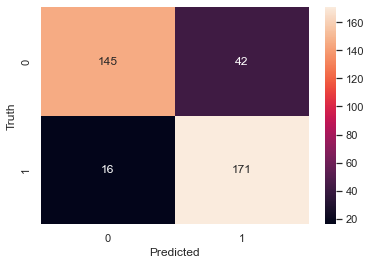

In [38]:
sn.set(style='white')
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [39]:
cr=classification_report(y_test,y_predicted)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.78      0.83       187
           1       0.80      0.91      0.85       187

    accuracy                           0.84       374
   macro avg       0.85      0.84      0.84       374
weighted avg       0.85      0.84      0.84       374



    | Inference

In [40]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews) # first three sentences are spam and other two are ham

1/1 [==============================] - 4s 4s/step


array([[0.6154235 ],
       [0.6576525 ],
       [0.6553732 ],
       [0.37146997],
       [0.31239557]], dtype=float32)